# EKF SLAM

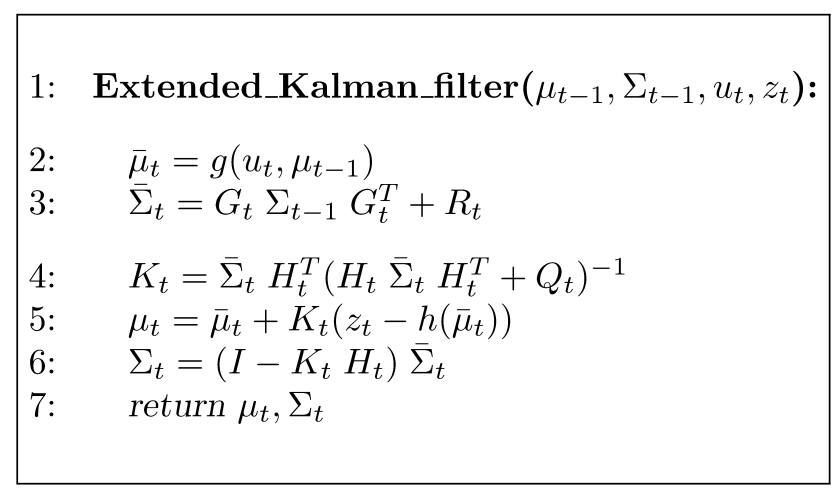

In [8]:
# load world and plot the state

import numpy as np
import matplotlib.pyplot as plt

world = np.loadtxt('C:/Users/soup1997/Desktop/slam_practice/dataset/world.dat')
print(world)

[[ 1.  2.  1.]
 [ 2.  0.  4.]
 [ 3.  2.  7.]
 [ 4.  9.  2.]
 [ 5. 10.  5.]
 [ 6.  9.  8.]
 [ 7.  5.  5.]
 [ 8.  5.  3.]
 [ 9.  5.  9.]]


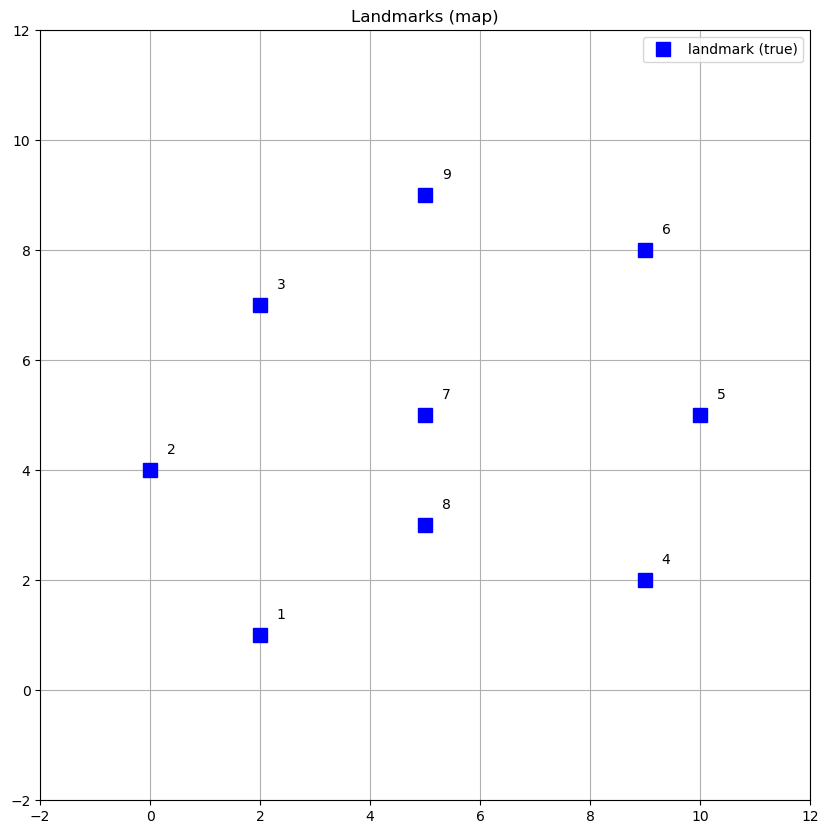

In [12]:
pos_x = world[:, 1]
pos_y = world[:, 2]

plt.figure(figsize=(10, 10))
plt.plot(world[:,1], world[:,2], 'bs', markersize=10)
plt.grid('on')
plt.axis('scaled')
plt.title('Landmarks (map)')

# landmark의 index plot
for i in range(len(world)):
    plt.text(world[i,1]+0.3, world[i,2]+0.3, str(int(world[i,0])))
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.legend(['landmark (true)'])
plt.show()

# Sensor Data

## SENSOR data fields
- id: id of the observed landmark
- range: mesured range to the landmark
- bearing: measured angle to the landmark

## ODOMETRY data fields
- r1: rotaion1
- t: translation
- r2: rotation2

In [15]:
sensor = []
odom = []
temp = []
save = False

with open('C:/Users/soup1997/Desktop/slam_practice/dataset/sensor_data.dat') as f:
    lines = f.readlines()
    i = 0

    for line in lines:
        line = line.replace('\n','')
        if 'ODOMETRY' in line:
            line = line.replace('ODOMETRY ', '')
            if save == False:
                save = True
                line = line.split(' ')
                line = np.array(line)
                line = line.astype(np.float32)
                odom.append(line)
            else:
                save = False
                sensor.append(temp)
                temp = []
                line = line.split(' ')
                line = np.array(line)
                line = line.astype(np.float32)
                odom.append(line)
                save = True
        else:
            line = line.replace('SENSOR ', '')
            line = line.split(' ')
            line = np.array(line)
            line = line.astype(np.float32)
            temp.append(line)
            
        if i == (len(lines) - 1):
            sensor.append(np.array(temp))
        i += 1

odom = np.array(odom)
sensor = np.array(sensor)

C:\Users\soup1997\AppData\Local\Temp\ipykernel_15356\3850293058.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sensor = np.array(sensor)


# Initialization

### 2N + 3 dimensions
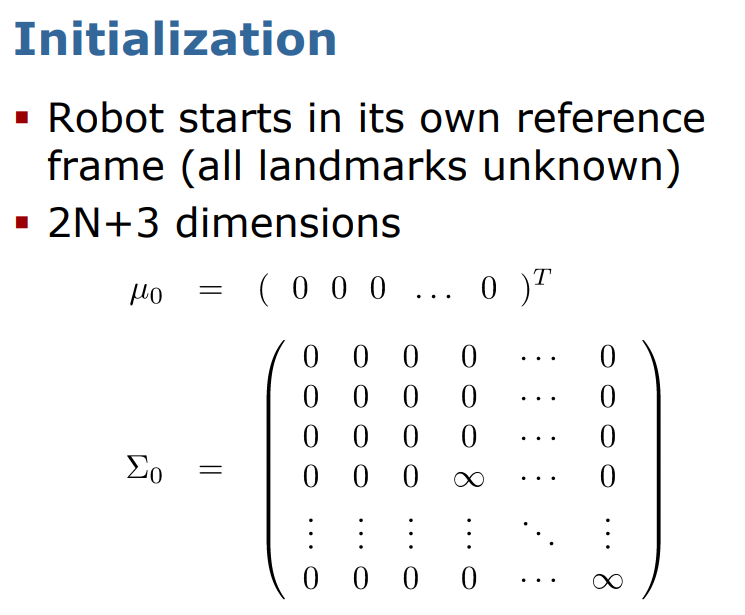

In [24]:
n = 3 # x, y, heading
m = 9 # number of landmarks

dim = n + (2 * m) # (x, y, heading), (landmark1 x, landmark1 y), ... 
P = np.eye(dim) # covariance matrix
P[:n, :n] = 1e-5 

R = np.diag([0.1, 0.1, 0.01]) # state uncertainty (system covariance)
Q = np.diag([10, 1] * m) # sensor에 관한 uncertainty (measurement covariance), [range uncertainty, angle uncertainty]

flag = np.zeros(9) # landmark가 측정되었는지에 관한 flag

print(R)
print(Q)

[[0.1  0.   0.  ]
 [0.   0.1  0.  ]
 [0.   0.   0.01]]
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  

# Robot Motion Model

In [22]:
import math

def norm_rot(theta):
    theta = math.atan2(math.sin(theta), math.cos(theta))
    return theta

def motion_model(x, odom):
    theta = x[2,0]

    rot1 = odom[0]
    t = odom[1]
    rot2 = odom[2]

    local_motion = np.zeros((3, 1))
    local_motion[0] = t * math.cos(theta + rot1) # position x
    local_motion[1] = t * math.sin(theta + rot1) # position y
    local_motion[2] = rot1 + rot2

    x_pred = x + local_motion
    x_pred[2, 0] = norm_rot(x_pred[2, 0])

    return x_pred

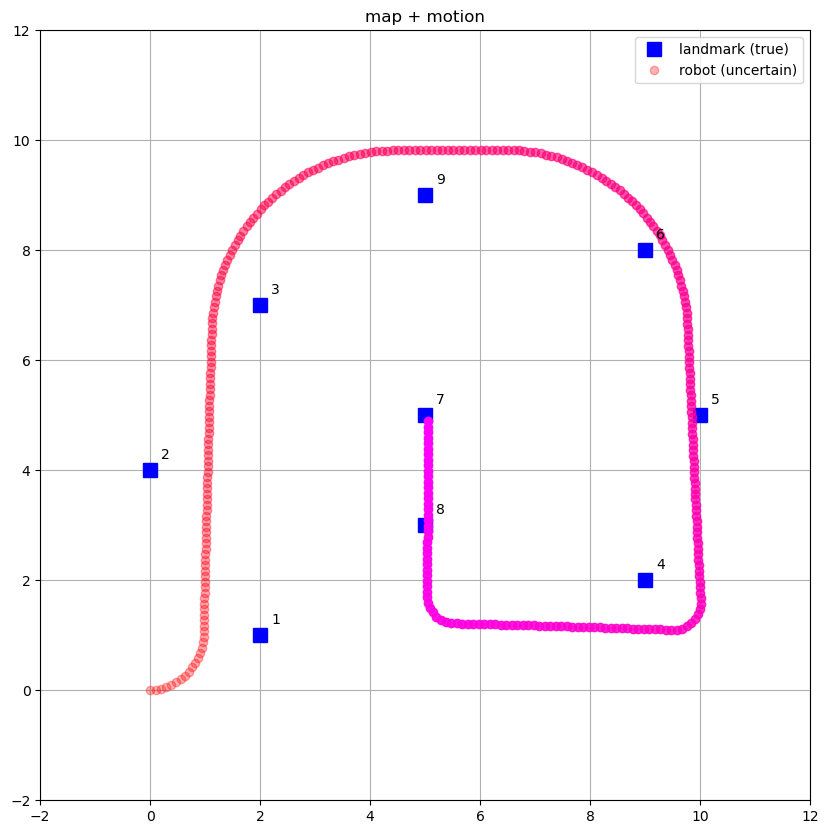

In [23]:
x = np.zeros((3,1)) # 초기 state 정의
motion_update_list = []
motion_update_list.append(x)

for i in range(len(odom)):
    x = motion_model(x, odom[i]) # motion update
    motion_update_list.append(x)

motion_update_list = np.array(motion_update_list)

# world(map) plot
plt.figure(figsize=[10,10])
plt.plot(world[:,1], world[:,2], 'bs', markersize=10)
plt.grid('on')
plt.title('map + motion')
for i in range(len(world)):
    plt.text(world[i,1]+0.2, world[i,2]+0.2, str(int(world[i,0])))

# robot trajectory plot
color = np.linspace([1, 0, 0, 0.3], [1, 0, 1, 1], len(motion_update_list))
for i in range(len(motion_update_list)):
    plt.plot(motion_update_list[i,0], motion_update_list[i,1], 'o', color=color[i])
plt.axis('scaled')
plt.legend(['landmark (true)', 'robot (uncertain)'])
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.show()

# EKF SLAM Prediction

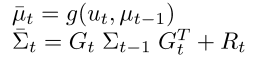

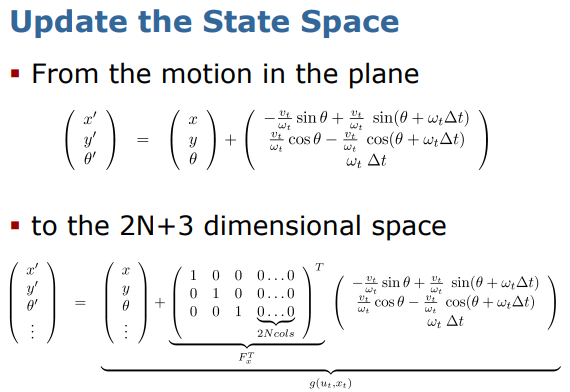

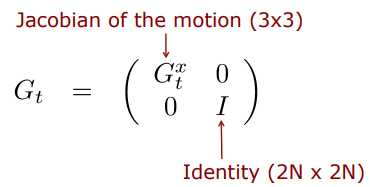

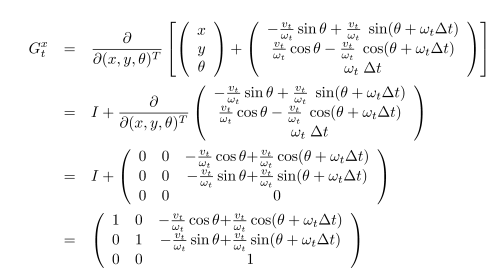


In [26]:
def prediction(x, u, P, R):
    theta = x[2, 0]

    rot1 = u[0]
    t = u[1]
    rot2 = u[2]

    F = np.zeros((n, dim))  # (n, n + 2m)
    F[:n, :n] = np.eye(n)

    local_motion = np.zeros((3, 1))
    local_motion[0] = t * math.cos(theta + rot1)

    local_motion[1] = t * math.sin(theta + rot1)

    local_motion[2] = rot2 + rot1 

    x_p = x + (F.T @ local_motion)
    x_p[2, 0] = norm_rot(x_p[2, 0])


    G = np.eye(dim)
    G[0, n-1] = -t * math.sin(theta + rot1)
    G[1, n-1] = t * math.cos(theta + rot1)

    R_temp = np.zeros((dim, dim))
    R_temp[:n, :n] = R    

    P_p = (G @ P @ G.T) + R_temp

    return x_p, P_p

# Correction
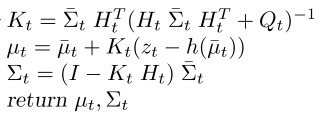

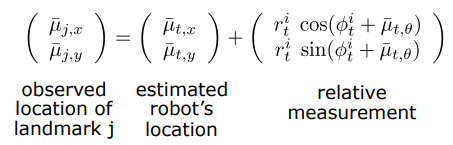

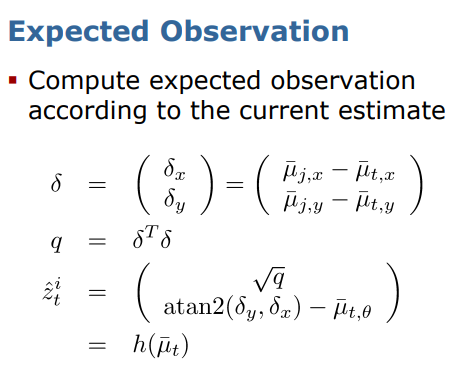

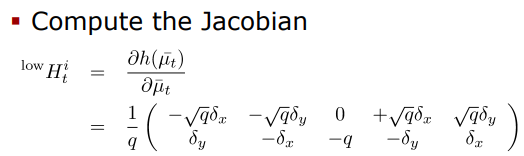

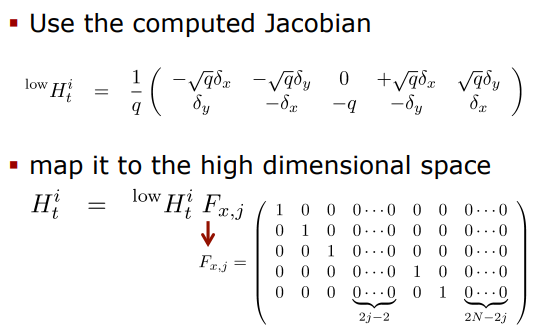

In [27]:
def correction(x, sensor, P, Q, flag):
    robot_x = x[0, 0]
    robot_y = x[1, 0]
    robot_theta = x[2, 0]

    y = np.zeros([2*m, 1])
    H = np.zeros([2*m, dim])
    
    # 각각의 랜드마크에 대한 correction 필요
    for i in range(len(sensor)):
        idx = int(sensor[i][0]) - 1 # landmark의 index
        r = sensor[i][1] # robot과 landmark 간 거리
        phi = sensor[i][2] # robot과 landmark 사이 각도
        z = np.array([r, phi])
        
        if flag[idx] == 0:
            ############### TODO: landmark 초기화 ###############
            # flag가 0이면 처음 보는 랜드마크, 이후에는 flag를 1로 변환
            # 이전에 측정되지 않은 랜드마크라면 초기화과정 필요
            # 2*idx + 3: sensor의 x 위치
            # 2*idx + 4: sensor의 y 위치 
            x[2*idx + 3, 0] = robot_x + r*math.cos(phi+robot_theta)
            x[2*idx + 4, 0] = robot_y + r*math.sin(phi+robot_theta)
            flag[idx] = 1
            ###################################################
        
        
        ################# TODO: sensor model 정의 #################
        sig = np.zeros([1, 2])
        sig[0][0]=x[2*idx+3,0]- robot_x
        sig[0][1]=x[2*idx+4,0]- robot_y
        
        q=sig@sig.T
        
        h = np.zeros([1, 2])
        h[0,0]=math.sqrt(q[0,0])
        h[0,1]=math.atan2(sig[0,1],sig[0,0]) - robot_theta
        ###########################################################
        e=np.zeros([2*m,1])
        
        e[2*idx:2*idx+2,0] = z - h
        e[2*idx+1, 0] = norm_rot(e[2*idx+1,0])
        
        ###################### TODO: F matrix 정의 ######################
        F = np.zeros([5, dim])
        F[0:3,0:3] = np.eye(3)
        F[3:5,2*idx+2:2*idx+4] = np.eye(2)
        ################################################################
        
        ###################### TODO: sensor model jacobian matrix 정의 ######################
        H_x = np.zeros([2, 5])
        H_x = 1/q[0,0]*(np.array([[-math.sqrt(q[0,0])*sig[0,0], -math.sqrt(q[0,0])*sig[0,1], 0, math.sqrt(q[0,0])*sig[0,0], math.sqrt(q[0,0])*sig[0,1]],
                                  [sig[0,1], -sig[0,0], -q[0,0], -sig[0,1], sig[0,0]]]))
        H[2*idx:2*idx+2, :] = H_x @ F
        ####################################################################################
    
    ############# TODO: correction step 작성 #############
    K = P@H.T@np.linalg.inv(H@P@H.T + Q)
    x_c = x + K@e
    x_c[2, 0] = norm_rot(x_c[2, 0])
    P_c = (np.eye(dim)-K@H)@P
    
    return x_c, P_c, flag

In [28]:
def ellipse(cov, x, y, color):
    w, v =np.linalg.eig(cov)
    t = np.linspace(0, 2*np.pi, 50)
    p90 = 1
    xx = (v[0,0]*np.sqrt(w[0])*np.cos(t) + v[0,1]*np.sqrt(w[1])*np.sin(t)) * 2 * np.sqrt(p90) + x
    yy = (v[1,0]*np.sqrt(w[0])*np.cos(t) + v[1,1]*np.sqrt(w[1])*np.sin(t)) * 2 * np.sqrt(p90) + y
    plt.plot(xx, yy, '--', color=color)

In [36]:
# Extend Kalman filter
x = np.zeros([dim, 1])

flag = np.zeros(9)

robot_xtotal = []
robot_ytotal = []

for i in range(330):
    print("step: {}".format(i))

    map_x = []
    map_y = []
    map_P = []

    x, P = prediction(x, odom[i], P, R)
    x, P, flag = correction(x, sensor[i], P, Q, flag)
    
    robot_x = x[0,0]
    robot_y = x[1,0]
    robot_xtotal.append(robot_x)
    robot_ytotal.append(robot_y)
    
    plt.figure(figsize=[10, 10])
    # ture map plot
    plt.plot(world[:,1], world[:,2], 'b s', markersize=10)

    plt.title('EKF SLAM in 2D space')

    for j in range(m):
        if flag[j] == 1:
            map_x.append(x[2*j+3,0])
            map_y.append(x[2*j+4,0])
            map_P.append(P[2*j+3:2*j+5, 2*j+3:2*j+5])
    
    # estimated map plot
    plt.plot(map_x, map_y, 's', color=[1, 0.5, 0], markersize=10)

    # robot position plot
    plt.plot(robot_xtotal, robot_ytotal, 'ro', markersize=5)

    # robot의 uncertainty plot
    ellipse(P[:2,:2], x[0,0], x[1,0], 'r')
    # map의 uncertainty plot
    for k in range(len(map_x)):
        ellipse(map_P[k], map_x[k], map_y[k], [1, 0.5, 0],)
    # robot이 측정한 landmark가 무엇인지 연결
    for p in range(len(sensor[i])):
        num = int(sensor[i][p][0]) - 1
        plt.plot([robot_x, x[3+2*num,0]], [robot_y, x[4+2*num, 0]], color=[1, 0.5, 0])
        
    plt.axis([-2, 12, -2, 12])
    plt.grid('on')
    plt.legend(['landmark (true)', 'landmark (estimated)', 'robot (estimated)'], fontsize=15, loc='upper right')
    plt.savefig('./figures/fig'+str(f'{i:03}')+'.png', dpi=300)
    plt.close()

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110


In [37]:
import glob
import cv2

img_array = []

for filename in sorted(glob.glob('./figures/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('./EKF_SLAM.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()